### Overfit 발생 모델, 데이터 표준화
#### 표준화 z값 = 평균: 0, 분산: 1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential      # class
from tensorflow.keras.models import load_model      # model 사용
from tensorflow.keras.layers import Dense           # 전결합
from tensorflow.keras.layers import Dropout         # 노드의 비활성화
from tensorflow.keras.callbacks import EarlyStopping # 학습 자동 중지
from tensorflow.keras import regularizers   # L1, L2 규제 적용

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  # K 겹 교차 검증
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

# Jupyter에게 matplotlib 그래프를 출력 영역에 표시할 것을 지시하는 명령
%matplotlib inline  

In [2]:
# data = np.loadtxt('./Survival.csv', delimiter=",", dtype=np.float64)
from sklearn import preprocessing

df = pd.read_csv('./Survival.csv', header=None)
print(type(df))
df_scaled = preprocessing.scale(df)  # 평균 0 분산 1로 표준화
print(type(df_scaled))     

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [3]:
df_scaled[0:2]

array([[ 0.42380062, -2.90454339,  0.59549804, -0.15045957, -1.46006711,
        -0.26573489, -0.41128364, -0.26573489, -1.48232213, -0.44607129,
         0.37609618, -0.28365431, -0.06537205, -0.13159034,  0.46649392,
        -0.06537205, -0.0614009 , -0.41833001],
       [-1.72836951, -1.51861914, -0.46140527, -0.20490295,  0.4097736 ,
        -0.26573489, -0.41128364, -0.26573489,  0.67461719,  2.24179415,
         3.22714787, -0.28365431, -0.06537205, -0.13159034,  0.46649392,
        -0.06537205, -0.29134848, -0.41833001]])

In [4]:
# 마지막 클래스까지 변경된 문제 발생
df2 = pd.DataFrame(df_scaled)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.423801,-2.904543,0.595498,-0.150460,-1.460067,-0.265735,-0.411284,-0.265735,-1.482322,-0.446071,0.376096,-0.283654,-0.065372,-0.131590,0.466494,-0.065372,-0.061401,-0.418330
1,-1.728370,-1.518619,-0.461405,-0.204903,0.409774,-0.265735,-0.411284,-0.265735,0.674617,2.241794,3.227148,-0.283654,-0.065372,-0.131590,0.466494,-0.065372,-0.291348,-0.418330
2,-1.676776,-1.518619,-0.105275,-0.175980,0.409774,-0.265735,-0.411284,-0.265735,0.674617,-0.446071,-1.049430,-0.283654,-0.065372,7.599342,0.466494,-0.065372,0.398494,2.390457
3,-1.632554,-1.518619,0.802283,-0.128342,2.279614,-0.265735,-0.411284,-0.265735,0.674617,2.241794,3.227148,-0.283654,-0.065372,-0.131590,0.466494,-0.065372,2.008127,2.390457
4,-1.610442,-1.518619,-1.231107,-0.228722,-1.460067,-0.265735,2.431412,-0.265735,-1.482322,-0.446071,0.376096,-0.283654,-0.065372,-0.131590,0.466494,-0.065372,-0.751244,-0.418330


In [42]:
# 마지막 컬럼은 라벨링 된 값이므로 표준화 하면 안됨(변형되면 안됨, 기준값)
df2.iloc[:, 17] = df.iloc[:, 17] 
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.507542,-2.028910,0.668967,-0.174813,-1.565093,-0.29756,-0.501495,-0.3253,-1.539795,-0.531233,0.227599,-0.287926,-0.069338,-0.139686,0.417322,0.0,-0.080308,0
1,-1.761302,-1.049598,-0.415503,-0.223943,0.314817,-0.29756,-0.501495,-0.3253,0.649437,1.882413,2.798848,-0.287926,-0.069338,-0.139686,0.417322,0.0,-0.316706,0
2,-1.706912,-1.049598,-0.050084,-0.197843,0.314817,-0.29756,-0.501495,-0.3253,0.649437,-0.531233,-1.058026,-0.287926,-0.069338,7.158911,0.417322,0.0,0.392489,1
3,-1.660292,-1.049598,0.881145,-0.154854,2.194727,-0.29756,-0.501495,-0.3253,0.649437,1.882413,2.798848,-0.287926,-0.069338,-0.139686,0.417322,0.0,2.047277,1
4,-1.636982,-1.049598,-1.205279,-0.245437,-1.565093,-0.29756,1.994039,-0.3253,-1.539795,-0.531233,0.227599,-0.287926,-0.069338,-0.139686,0.417322,0.0,-0.789502,0


In [5]:
data = df2.values;  # Pandas DataFrame -> Numpy Array로 변환
print(type(data))
print(data.shape)
print(data[0:3])

<class 'numpy.ndarray'>
(470, 18)
[[ 0.42380062 -2.90454339  0.59549804 -0.15045957 -1.46006711 -0.26573489
  -0.41128364 -0.26573489 -1.48232213 -0.44607129  0.37609618 -0.28365431
  -0.06537205 -0.13159034  0.46649392 -0.06537205 -0.0614009  -0.41833001]
 [-1.72836951 -1.51861914 -0.46140527 -0.20490295  0.4097736  -0.26573489
  -0.41128364 -0.26573489  0.67461719  2.24179415  3.22714787 -0.28365431
  -0.06537205 -0.13159034  0.46649392 -0.06537205 -0.29134848 -0.41833001]
 [-1.67677639 -1.51861914 -0.1052748  -0.17597991  0.4097736  -0.26573489
  -0.41128364 -0.26573489  0.67461719 -0.44607129 -1.04942966 -0.28365431
  -0.06537205  7.59934208  0.46649392 -0.06537205  0.39849428  2.39045722]]


In [6]:
X = data[:, 0:17] # 0 ~ 16: 17개
print(X.shape)
Y = data[:, 17]   # 17: 1개, 마지막 분류값
print(Y.shape)

(470, 17)
(470,)


In [7]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기(x_train_all), 10%: 테스트(x_test)
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                          stratify=Y,
                                                          test_size=0.1,
                                                          random_state=seed)
# 약한 Overfit
# 나머지 데이터 90%를 분할, 70%: 훈련(x_train), 30%: 검증(x_val)

# 강한 Overfit
# 나머지 데이터 90%를 분할, 90%: 훈련(x_train), 10%: 검증(x_val)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.1,
                                                  random_state=seed)

print(y_val[0:100])
print(y_val.shape)

[-0.41833001 -0.41833001 -0.41833001  2.39045722 -0.41833001 -0.41833001
 -0.41833001 -0.41833001 -0.41833001 -0.41833001 -0.41833001  2.39045722
 -0.41833001 -0.41833001 -0.41833001 -0.41833001 -0.41833001 -0.41833001
 -0.41833001  2.39045722 -0.41833001 -0.41833001 -0.41833001 -0.41833001
 -0.41833001 -0.41833001 -0.41833001 -0.41833001 -0.41833001  2.39045722
 -0.41833001  2.39045722 -0.41833001 -0.41833001 -0.41833001 -0.41833001
 -0.41833001 -0.41833001 -0.41833001 -0.41833001  2.39045722 -0.41833001
 -0.41833001]
(43,)


In [8]:
model = Sequential()
# model.add(Dense(128, input_dim=17, activation='linear')) # 첫번째 은닉층
model.add(Dense(128, input_shape=(17, ), activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.0005))) # 첫번째 은닉층
model.add(Dropout(0.2)) # 10% 비활성화, Node의 값을 0으로 변경

model.add(Dense(64, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.0005)))
model.add(Dropout(0.2)) # 10% 비활성화, Node의 값을 0으로 변경

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2)) # 10% 비활성화, Node의 값을 0으로 변경

model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # 출력층, 입력: 15, 출력 1

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# 최소 오차 10번 나오면 자동 종료
early_stopping = EarlyStopping(monitor='loss', patience=5)

# 학습
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                 epochs=1000, 
                 batch_size=2, callbacks=[early_stopping])

Train on 380 samples, validate on 43 samples
Epoch 1/1000
380/380 [==============================] - 2s 4ms/sample - loss: 0.9131 - accuracy: 0.0000e+00 - val_loss: 0.2654 - val_accuracy: 0.0000e+00
Epoch 2/1000
380/380 [==============================] - 0s 786us/sample - loss: 0.1424 - accuracy: 0.0000e+00 - val_loss: -1.2054 - val_accuracy: 0.0000e+00
Epoch 3/1000
380/380 [==============================] - 0s 785us/sample - loss: -2.4482 - accuracy: 0.0000e+00 - val_loss: -34.5563 - val_accuracy: 0.0000e+00
Epoch 4/1000
380/380 [==============================] - 0s 751us/sample - loss: -88.2281 - accuracy: 0.0000e+00 - val_loss: -246.9769 - val_accuracy: 0.0000e+00
Epoch 5/1000
380/380 [==============================] - 0s 745us/sample - loss: -755.3453 - accuracy: 0.0000e+00 - val_loss: -1833.6645 - val_accuracy: 0.0000e+00
Epoch 6/1000
380/380 [==============================] - 0s 826us/sample - loss: -5129.5900 - accuracy: 0.0000e+00 - val_loss: -10010.3085 - val_accuracy: 0.0000e

Epoch 49/1000
380/380 [==============================] - 0s 771us/sample - loss: -455758906.4915 - accuracy: 0.0000e+00 - val_loss: -509292811.8974 - val_accuracy: 0.0000e+00
Epoch 50/1000
380/380 [==============================] - 0s 788us/sample - loss: -508376573.9268 - accuracy: 0.0000e+00 - val_loss: -552117941.0209 - val_accuracy: 0.0000e+00
Epoch 51/1000
380/380 [==============================] - 0s 695us/sample - loss: -549394468.1812 - accuracy: 0.0000e+00 - val_loss: -599678277.2088 - val_accuracy: 0.0000e+00
Epoch 52/1000
380/380 [==============================] - 0s 790us/sample - loss: -579446017.3154 - accuracy: 0.0000e+00 - val_loss: -646402726.1461 - val_accuracy: 0.0000e+00
Epoch 53/1000
380/380 [==============================] - 0s 773us/sample - loss: -642792851.0363 - accuracy: 0.0000e+00 - val_loss: -696524566.7079 - val_accuracy: 0.0000e+00
Epoch 54/1000
380/380 [==============================] - 0s 771us/sample - loss: -672625873.0444 - accuracy: 0.0000e+00 - val

380/380 [==============================] - 0s 805us/sample - loss: -7286995609.4440 - accuracy: 0.0000e+00 - val_loss: -7774410759.6357 - val_accuracy: 0.0000e+00
Epoch 96/1000
380/380 [==============================] - 0s 797us/sample - loss: -7769503258.1090 - accuracy: 0.0000e+00 - val_loss: -8139165798.7504 - val_accuracy: 0.0000e+00
Epoch 97/1000
380/380 [==============================] - 0s 768us/sample - loss: -8320315700.4867 - accuracy: 0.0000e+00 - val_loss: -8515225696.6512 - val_accuracy: 0.0000e+00
Epoch 98/1000
380/380 [==============================] - 0s 835us/sample - loss: -8189126845.8740 - accuracy: 0.0000e+00 - val_loss: -8888578852.7923 - val_accuracy: 0.0000e+00
Epoch 99/1000
380/380 [==============================] - 0s 785us/sample - loss: -8539727060.0802 - accuracy: 0.0000e+00 - val_loss: -9227188665.3158 - val_accuracy: 0.0000e+00
Epoch 100/1000
380/380 [==============================] - 0s 792us/sample - loss: -9131243972.1785 - accuracy: 0.0000e+00 - val_l

Epoch 141/1000
380/380 [==============================] - 0s 739us/sample - loss: -37133338415.7752 - accuracy: 0.0000e+00 - val_loss: -39651696898.6878 - val_accuracy: 0.0000e+00
Epoch 142/1000
380/380 [==============================] - 0s 793us/sample - loss: -38087119367.3824 - accuracy: 0.0000e+00 - val_loss: -40751916004.7503 - val_accuracy: 0.0000e+00
Epoch 143/1000
380/380 [==============================] - 0s 740us/sample - loss: -39309856853.6580 - accuracy: 0.0000e+00 - val_loss: -41944624791.1770 - val_accuracy: 0.0000e+00
Epoch 144/1000
380/380 [==============================] - 0s 746us/sample - loss: -38168193820.9474 - accuracy: 0.0000e+00 - val_loss: -43173174839.7528 - val_accuracy: 0.0000e+00
Epoch 145/1000
380/380 [==============================] - 0s 805us/sample - loss: -40502033614.0659 - accuracy: 0.0000e+00 - val_loss: -44418878745.8032 - val_accuracy: 0.0000e+00
Epoch 146/1000
380/380 [==============================] - 0s 764us/sample - loss: -41503214350.6329 

380/380 [==============================] - 0s 807us/sample - loss: -123090130570.2368 - accuracy: 0.0000e+00 - val_loss: -127625877765.6873 - val_accuracy: 0.0000e+00
Epoch 187/1000
380/380 [==============================] - 0s 726us/sample - loss: -127402410707.9304 - accuracy: 0.0000e+00 - val_loss: -130635255164.5330 - val_accuracy: 0.0000e+00
Epoch 188/1000
380/380 [==============================] - 0s 819us/sample - loss: -122367262329.3415 - accuracy: 0.0000e+00 - val_loss: -133733756284.3065 - val_accuracy: 0.0000e+00
Epoch 189/1000
380/380 [==============================] - 0s 788us/sample - loss: -130694310613.3595 - accuracy: 0.0000e+00 - val_loss: -136706102985.4834 - val_accuracy: 0.0000e+00
Epoch 190/1000
380/380 [==============================] - 0s 781us/sample - loss: -128145573299.9210 - accuracy: 0.0000e+00 - val_loss: -140016240567.3950 - val_accuracy: 0.0000e+00
Epoch 191/1000
380/380 [==============================] - 0s 782us/sample - loss: -128921526286.2086 - ac

380/380 [==============================] - 0s 774us/sample - loss: -303574173731.1892 - accuracy: 0.0000e+00 - val_loss: -329742998564.4399 - val_accuracy: 0.0000e+00
Epoch 232/1000
380/380 [==============================] - 0s 778us/sample - loss: -305913012846.1137 - accuracy: 0.0000e+00 - val_loss: -335802154591.7242 - val_accuracy: 0.0000e+00
Epoch 233/1000
380/380 [==============================] - 0s 736us/sample - loss: -326710220548.1682 - accuracy: 0.0000e+00 - val_loss: -342168695796.2910 - val_accuracy: 0.0000e+00
Epoch 234/1000
380/380 [==============================] - 0s 796us/sample - loss: -322479395614.9661 - accuracy: 0.0000e+00 - val_loss: -348339392380.9725 - val_accuracy: 0.0000e+00
Epoch 235/1000
380/380 [==============================] - 0s 732us/sample - loss: -338320849884.9684 - accuracy: 0.0000e+00 - val_loss: -355086602870.7469 - val_accuracy: 0.0000e+00
Epoch 236/1000
380/380 [==============================] - 0s 797us/sample - loss: -346665075496.1675 - ac

380/380 [==============================] - 0s 792us/sample - loss: -649481801558.2570 - accuracy: 0.0000e+00 - val_loss: -718999289897.6744 - val_accuracy: 0.0000e+00
Epoch 277/1000
380/380 [==============================] - 0s 808us/sample - loss: -696123832530.1439 - accuracy: 0.0000e+00 - val_loss: -730885009652.8372 - val_accuracy: 0.0000e+00
Epoch 278/1000
380/380 [==============================] - 0s 834us/sample - loss: -688454917612.3352 - accuracy: 0.0000e+00 - val_loss: -743207776070.6976 - val_accuracy: 0.0000e+00
Epoch 279/1000
380/380 [==============================] - 0s 802us/sample - loss: -719479883707.8721 - accuracy: 0.0000e+00 - val_loss: -756032728474.6046 - val_accuracy: 0.0000e+00
Epoch 280/1000
380/380 [==============================] - 0s 889us/sample - loss: -741517166941.7885 - accuracy: 0.0000e+00 - val_loss: -768059846050.2325 - val_accuracy: 0.0000e+00
Epoch 281/1000
380/380 [==============================] - 0s 800us/sample - loss: -739924590367.8855 - ac

Epoch 321/1000
380/380 [==============================] - 0s 797us/sample - loss: -1309000808611.2341 - accuracy: 0.0000e+00 - val_loss: -1414105981332.8372 - val_accuracy: 0.0000e+00
Epoch 322/1000
380/380 [==============================] - 0s 825us/sample - loss: -1368740270779.7222 - accuracy: 0.0000e+00 - val_loss: -1435309031173.9534 - val_accuracy: 0.0000e+00
Epoch 323/1000
380/380 [==============================] - 0s 862us/sample - loss: -1373909140977.0701 - accuracy: 0.0000e+00 - val_loss: -1454067897998.8838 - val_accuracy: 0.0000e+00
Epoch 324/1000
380/380 [==============================] - 0s 844us/sample - loss: -1392867922469.8708 - accuracy: 0.0000e+00 - val_loss: -1474663456696.5581 - val_accuracy: 0.0000e+00
Epoch 325/1000
380/380 [==============================] - 0s 845us/sample - loss: -1462962476396.6946 - accuracy: 0.0000e+00 - val_loss: -1497286761472.0000 - val_accuracy: 0.0000e+00
Epoch 326/1000
380/380 [==============================] - 0s 805us/sample - loss

380/380 [==============================] - 0s 812us/sample - loss: -2348641557751.0034 - accuracy: 0.0000e+00 - val_loss: -2503523834475.1626 - val_accuracy: 0.0000e+00
Epoch 366/1000
380/380 [==============================] - 0s 793us/sample - loss: -2534587017322.6426 - accuracy: 0.0000e+00 - val_loss: -2538359654781.0234 - val_accuracy: 0.0000e+00
Epoch 367/1000
380/380 [==============================] - 0s 796us/sample - loss: -2451288799518.1680 - accuracy: 0.0000e+00 - val_loss: -2571450959300.4653 - val_accuracy: 0.0000e+00
Epoch 368/1000
380/380 [==============================] - 0s 801us/sample - loss: -2452713334909.9111 - accuracy: 0.0000e+00 - val_loss: -2602154234308.4653 - val_accuracy: 0.0000e+00
Epoch 369/1000
380/380 [==============================] - 0s 809us/sample - loss: -2460093548826.0464 - accuracy: 0.0000e+00 - val_loss: -2634511265053.7676 - val_accuracy: 0.0000e+00
Epoch 370/1000
380/380 [==============================] - 0s 800us/sample - loss: -246320194158

In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               2304      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 15)               

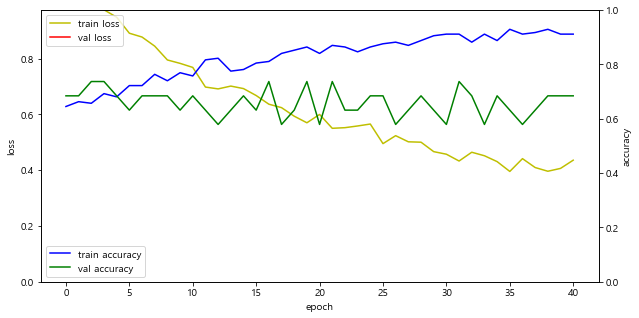

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.9740]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [49]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 2.3914062685909725 /정확도: 61.90476417541504 %


In [50]:
model.save('./Overfit.h5')

(21, 17)


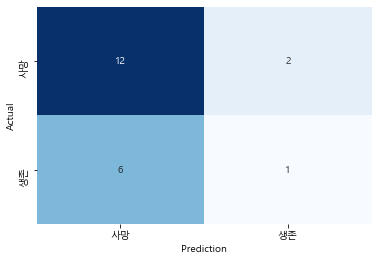

[[12  2]
 [ 6  1]]


<Figure size 432x288 with 0 Axes>

In [51]:
# 결과 - 혼동 행렬
print(x_test.shape)
y_test_pred = model.predict_classes(x_test)
c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sb.heatmap(c_matrix, annot=True, 
                 xticklabels=['사망', '생존'], 
                 yticklabels=['사망', '생존'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()
plt.clf()
print(c_matrix)

# [[490   0]
#  [ 12 148]]
# [[사망자 맞춘 갯수   사망자 틀린 갯수]
#  [생존자 틀린 갯수   생존자 맞춘갯수]]

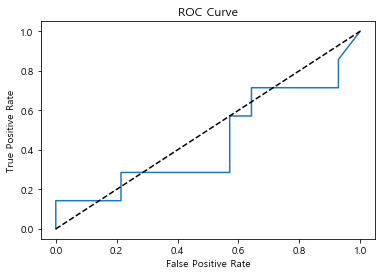

<Figure size 432x288 with 0 Axes>

In [52]:
# 결과 - ROC 곡선
y_test_pred_probs = model.predict(x_test)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()